<a href="https://colab.research.google.com/github/Nohyunsun/ADHD-Self-Diagnosis-Across-Platforms/blob/main/platform_kpi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📊 Platform KPI + WordCloud (Colab-Ready)

이 노트북은 `all_mapped.csv`를 기반으로 **플랫폼별 워드클라우드**와 **KPI 지수(좋아요/댓글/조회수)**를 계산하고,
**연도별 비교** 및 **합성 KPI 점수(정규화 기반)**까지 산출합니다.

## ✅ 기대 결과
- 플랫폼별 WordCloud 이미지
- KPI 요약 테이블(전체 기간 평균)
- 연도별 KPI 변화 테이블
- 합성 KPI 점수(레코드 단위 및 플랫폼/연도 단위 평균)
- 결과 CSV 및 이미지 파일 저장/다운로드

----
### 입력 데이터 가정 컬럼
`platform`, `text`, `likecount`, `commentcount`, `viewcount`, `date`

필수는 `platform`, `text`이며 KPI 컬럼이 비어있으면 자동으로 0으로 처리합니다. `date`가 있으면 연도별 집계를 수행합니다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1) 환경 설치 (한글 폰트 & 필수 라이브러리)
- **WordCloud** 설치
- **Nanum 폰트 설치** (한글 워드클라우드용)

> Colab 환경에서만 실행하세요.

In [ ]:
!pip -q install wordcloud==1.9.3
try:
    # Colab 환경에서만 동작 (무시 가능)
    import google.colab  # noqa
    !apt-get -qq update
    !apt-get -qq install fonts-nanum > /dev/null
    print("✅ Nanum fonts installed.")
except Exception as e:
    print("(Info) Not running on Colab or apt-get unavailable.")
    print(e)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.6/541.6 kB 12.3 MB/s eta 0:00:00
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
✅ Nanum fonts installed.


## 2) 라이브러리 로드 & 폰트 경로 설정

In [ ]:
import os, re, zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from datetime import datetime

# matplotlib 제약: 색상 지정/스타일 지정 없이, 단일 플롯만 사용
plt.rcParams['axes.unicode_minus'] = False

def find_korean_font_path():
    candidates = [
        "/usr/share/fonts/truetype/nanum/NanumGothic.ttf",
        "/usr/share/fonts/truetype/noto/NotoSansCJK-Regular.ttc",
        "/usr/share/fonts/truetype/noto/NotoSansCJK-Regular.otf",
        "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc",
    ]
    for p in candidates:
        if os.path.exists(p):
            return p
    return None

KOREAN_FONT = find_korean_font_path()
print("Font path:", KOREAN_FONT)


Font path: /usr/share/fonts/truetype/nanum/NanumGothic.ttf


## 3) 데이터 불러오기
로컬로 CSV 업로드하거나, Colab 경로에 `all_mapped.csv`가 있는지 확인합니다.

- like, comment, view

In [ ]:
CSV_PATH = '/content/drive/MyDrive/졸업논문/all_mapped.csv'  # 필요시 변경

if not os.path.exists(CSV_PATH):
    try:
        from google.colab import files
        print("`all_mapped.csv`를 업로드 해주세요.")
        uploaded = files.upload()
        CSV_PATH = list(uploaded.keys())[0]
    except Exception:
        pass

df = pd.read_csv(CSV_PATH)
print("✅ Data loaded:", df.shape)
display(df.head(3))

required_cols = ['platform','text']
for rc in required_cols:
    if rc not in df.columns:
        raise ValueError(f"필수 컬럼 누락: {rc}")

# KPI 컬럼 보정
for col in ['likecount','commentcount','viewcount']:
    if col not in df.columns:
        df[col] = np.nan
df[['likecount','commentcount','viewcount']] = df[['likecount','commentcount','viewcount']].fillna(0)

# 연도 파생
if 'date' in df.columns:
    df['year'] = pd.to_datetime(df['date'], errors='coerce').dt.year
else:
    df['year'] = np.nan

platforms = df['platform'].dropna().astype(str).unique().tolist()
print("📱 Platforms:", platforms)


✅ Data loaded: (2551, 10)


,platform,url,author,title,text,created_at,likecount,commentcount,retweetcount,viewcount
0,x,https://x.com/___ad_astra_/status/186976052367...,___ad_astra_,NaN,검사해보면 패션adhd에 불과할 뿐인 내가 자꾸 adhd랑 증상겹치는 현상이 생겨서...,2024,0,0.0,0.0,367.0
1,x,https://x.com/k0mmSussxrT0d/status/18675960060...,k0mmSussxrT0d,NaN,당신adhd아니야 의사한테진단받은거아니고니가자가진단한거잔아mbti검사마냥 너는그냥너...,2024,8,1.0,8.0,874.0
2,x,https://x.com/Defaxine/status/1866813936710099038,Defaxine,NaN,ADHD 자가진단이라는데 일 마무리 잘 하고 어떤 일이든 순서대로 끝내고 약속 잘 ...,2024,28,3.0,10.0,4256.0


📱 Platforms: ['x', 'instagram', 'blog', 'youtube']


- like, comment

In [ ]:
CSV_PATH = '/content/drive/MyDrive/졸업논문/all_mapped.csv'  # 필요시 변경

if not os.path.exists(CSV_PATH):
    try:
        from google.colab import files
        print("`all_mapped.csv`를 업로드 해주세요.")
        uploaded = files.upload()
        CSV_PATH = list(uploaded.keys())[0]
    except Exception:
        pass

df = pd.read_csv(CSV_PATH)
print("✅ Data loaded:", df.shape)
display(df.head(3))

required_cols = ['platform','text']
for rc in required_cols:
    if rc not in df.columns:
        raise ValueError(f"필수 컬럼 누락: {rc}")

# KPI 컬럼 보정
for col in ['likecount','commentcount']:
    if col not in df.columns:
        df[col] = np.nan
df[['likecount','commentcount']] = df[['likecount','commentcount']].fillna(0)

# 연도 파생
if 'date' in df.columns:
    df['year'] = pd.to_datetime(df['date'], errors='coerce').dt.year
else:
    df['year'] = np.nan

platforms = df['platform'].dropna().astype(str).unique().tolist()
print("📱 Platforms:", platforms)


✅ Data loaded: (2551, 10)


,platform,url,author,title,text,created_at,likecount,commentcount,retweetcount,viewcount
0,x,https://x.com/___ad_astra_/status/186976052367...,___ad_astra_,NaN,검사해보면 패션adhd에 불과할 뿐인 내가 자꾸 adhd랑 증상겹치는 현상이 생겨서...,2024,0,0.0,0.0,367.0
1,x,https://x.com/k0mmSussxrT0d/status/18675960060...,k0mmSussxrT0d,NaN,당신adhd아니야 의사한테진단받은거아니고니가자가진단한거잔아mbti검사마냥 너는그냥너...,2024,8,1.0,8.0,874.0
2,x,https://x.com/Defaxine/status/1866813936710099038,Defaxine,NaN,ADHD 자가진단이라는데 일 마무리 잘 하고 어떤 일이든 순서대로 끝내고 약속 잘 ...,2024,28,3.0,10.0,4256.0


📱 Platforms: ['x', 'instagram', 'blog', 'youtube']


## 4) 텍스트 정제 + 불용어 설정
- URL/이모지/기호 제거
- 한글/영문 단어만 추출, 2자 이상 토큰만 유지
- 커스텀 불용어(stopwords)를 적용 (필요시 수정)

> 형태소 분석기 없이도 동작하도록 설계 (Colab에서 추가 설치 불요)

In [ ]:
BASE_STOPWORDS = set([
    # 한국어 일반 불용어 (필요시 확장)
    '영상','조회','댓글','공유','테스트','자가진단','링크','클릭','보기','하기','입니다','이런','하는','하게','때문','정말','그냥','지금',
    '생각','사람','진짜','오늘','우리','나','그리고','하지만','그래서','거나','부터','까지','에서','에게','으로','대한','관련','내용','정보',
    '제공','공지','업로드','혹시','은', '는', '이', '가', '을', '를', '에', '에서', '으로', '와', '과', '도', '만', '처럼','의', '에게', '께',
    '보다', '마다', '한테', '하고', '부터', '까지','으로서', '으로써', '으로부터', '이며', '이며', '으로도', '으로만','그리고', '그러나',
    '그래서', '그런데', '하지만', '또', '또는', '또한','요', '니다', '습니다', '네요', '세요', '이요', '죠', '아요', '어요', '였어요','하다',
    '합니다', '해요', '했어요', '하고있어요', '했는데', '했지만','입니다', '있습니다', '없습니다', '있어요', '없어요','정말', '진짜', '너무',
    '매우', '많이', '아주', '좀', '조금', '그냥', '거의','이건', '이게', '저건', '그건', '그게', '저게', '이런', '그런', '저런','이거', '그거',
    '저거', '뭐', '뭔가', '뭘', '누가', '내가', '내', '너', '니', '우리','입니다만', '같아요', '같은', '정도', '경우', '때문에', '때문', '통해',
    '위해','거든요', '잖아요', '요즘', '최근', '오늘', '지금', '입니다요', '인데요','혹시', '그럼', '그래도', '그래요', '맞아요', '그렇죠',
    '아니요', '아니라', '아니고','예요', '이에요', '입니다만', '이었습니다', '였습니다','를','로','했는데','가','은','는','이','한','할','하고'
    '입니다.', '합니다.', '있습니다.', '있어요.', '없어요.', '않아요.', '않습니다.','하는', '하는데', '했다', '했다고', '하고', '하며', '하는중',
    '하고싶다','보면', '보니까', '보았는데', '봤는데', '봤어요', '봤을때','입니다만', '아니고', '아닌', '아닌데', '아닐까', '아니에요', '아닙니다',
    '또한', '하지만', '그래서', '그러니까', '때문에', '그렇지만','나도', '저도', '너도', '우리도', '모두', '다들', '다같이','안녕하세요', '있습니다',
    '있어요', '합니다', '합니다.', '입니다', '있습니다.','이런식으로', '이렇게', '그렇게', '저렇게', '이러면', '저러면', '그래서', '때문에','등의',
    '등은', '등을', '등도', '등으로','같이', '함께', '통해', '통하여', '대한', '대해', '대해서', '대하여','요.', '.', '!', '?', '…'
])

# 사용자 추가/제거 가능 영역
CUSTOM_STOPWORDS = set([
      '같은데', '같은', '이런한', '이런', '그런', '저런', '이러한', '그러한','있음', '있는', '없는', '있다고', '없다고', '있다', '없다', '있을', '없을', '있어서', '없어서',
      '하게', '하게될', '하게되면', '하게되어', '하게됨', '하게됩니다', '하게되었다','나는', '내가', '저는', '제가', '너는', '우리는', '우리', '누가', '누군가', '사람들이',
      '중', '중에', '중인', '중에서', '경우', '경우에', '경우는', '경우가','것', '것이', '것도', '거', '거의', '거라', '거에요', '거예요', '거죠','하는', '하면', '하며',
      '하고', '해서', '했다', '했는데', '한', '할', '하게', '하려고','된다', '된다면', '됩니다', '된', '되면', '되어', '되어서', '되었다', '될', '되기', '되니까','정확한',
      '정확하게', '정확히', '짧은', '높은', '낮은', '많은', '많이', '적은', '더', '가장', '크게', '작게','오늘은', '오늘', '최근', '요즘', '현재', '지금', '앞으로', '이번',
      '지난', '다음', '또한','입니다', '합니다', '됩니다', '있습니다', '없습니다', '있어요', '없어요','아니고', '아니며', '아닌', '아니다', '아니라', '아닙니다', '아니었어요',
      '으로', '로', '에서', '부터', '까지', '에', '에게', '께', '라도', '이나', '이나요', '거나','더', '너무', '매우', '아주', '진짜', '정말', '조금', '약간', '다소', '또',
      '또는', '그래서','다른', '다르게', '같은', '같이', '비슷한', '비슷하게', '비슷함', '비슷하여', '이며', '이라서', '이라며', '이라도', '이라기보단','자신의', '자기', '자신',
      '으로', '은', '이', '을', '의','는','를','로','에','한','에서','하고','받고','있습니다', '없습니다', '입니다.', '합니다.', '있어요.', '없어요.', '같아요.', '맞아요.',
      '이요', '요', '네요', '죠', '아요', '어요', '네요', '에요', '예요','이런데', '그런데', '근데', '하지만', '그래도', '그렇지만', '그래서','pass', 'short', 'video', 'nan',
      'test', 'adhd', '성인'
])

STOPWORDS = BASE_STOPWORDS.union(CUSTOM_STOPWORDS)

def clean_text_basic(s: str) -> str:
    s = str(s)
    # URL, 해시태그/멘션, 특수문자 제거
    s = re.sub(r'https?://\S+|www\.\S+', ' ', s)
    s = re.sub(r'[@#]\w+', ' ', s)
    s = re.sub(r'[^0-9A-Za-z가-힣\s]', ' ', s)
    s = re.sub(r'\s+', ' ', s)
    s = s.strip().lower()
    return s

def tokenize_ko_en(s: str):
    # 한글/영문/숫자 연속 토큰으로 분리
    tokens = re.findall(r'[가-힣]{2,}|[a-zA-Z]{2,}|[0-9]{2,}', s)
    # 불용어 제거
    tokens = [t for t in tokens if t not in STOPWORDS]
    return tokens

def build_clean_text_column(dataframe):
    texts = []
    for t in dataframe['text'].astype(str).tolist():
        s = clean_text_basic(t)
        toks = tokenize_ko_en(s)
        texts.append(' '.join(toks))
    return texts

df['clean_text'] = build_clean_text_column(df)
display(df[['platform','text','clean_text']].head(5))

,platform,text,clean_text
0,x,검사해보면 패션adhd에 불과할 뿐인 내가 자꾸 adhd랑 증상겹치는 현상이 생겨서...,검사해보면 패션 불과할 뿐인 자꾸 증상겹치는 현상이 생겨서 머리를 쥐어뜯고 우울증을...
1,x,당신adhd아니야 의사한테진단받은거아니고니가자가진단한거잔아mbti검사마냥 너는그냥너...,당신 아니야 의사한테진단받은거아니고니가자가진단한거잔아 mbti 검사마냥 너는그냥너의...
2,x,ADHD 자가진단이라는데 일 마무리 잘 하고 어떤 일이든 순서대로 끝내고 약속 잘 ...,자가진단이라는데 마무리 어떤 일이든 순서대로 끝내고 약속 지키고 미루고 가만히 있고...
3,x,주변에 ADHD환자가 엄청 많아서 나도 기억력 저하가 많이 심각해서 혹시..? 했지...,주변에 환자가 엄청 많아서 기억력 저하가 심각해서 간단자가진단 항목에 일부만 해당하...
4,x,애초에 adhd 자가진단에서 정상이 나오는 사람이 있긴함? 항목이 물건을잘잃어버린다...,애초에 자가진단에서 정상이 나오는 사람이 있긴함 항목이 물건을잘잃어버린다 잘넘어진다...


## 5) KPI 계산 (평균 & 연도별)

In [ ]:
# 전체 기간 평균 KPI (플랫폼 단위)
kpi_overall = (
    df.groupby('platform')[['likecount','commentcount']]
      .mean().round(3)
)
kpi_overall['n_posts'] = df.groupby('platform')['platform'].count()

print("\n📊 전체 기간 KPI(평균) — 플랫폼 단위")
display(kpi_overall)

# 연도별 KPI (플랫폼 × 연도 평균)
if df['created_at'].notnull().any():
    kpi_yearly = (
        df.dropna(subset=['created_at'])
          .groupby(['platform','created_at'])[['likecount','commentcount']]
          .mean().round(3)
    )
    print("\n📈 연도별 KPI(평균) — 플랫폼×연도")
    display(kpi_yearly)
else:
    kpi_yearly = pd.DataFrame()
    print("⚠️ 연도 정보가 없어 연도별 KPI는 생략됩니다.")

# 저장
os.makedirs('outputs', exist_ok=True)
kpi_overall.to_csv('outputs/kpi_overall.csv', index=True)
kpi_yearly.to_csv('outputs/kpi_yearly.csv', index=True)
print("✅ Saved: outputs/kpi_overall.csv, outputs/kpi_yearly.csv")



📊 전체 기간 KPI(평균) — 플랫폼 단위


,likecount,commentcount,n_posts
platform,,,
blog,15.664,3.051,1170
instagram,107.483,15.638,58
x,8.417,0.388,585
youtube,13169.862,1321.371,738



📈 연도별 KPI(평균) — 플랫폼×연도


likecount  commentcount
platform  created_at                         
blog      2022           26.250         4.156
          2023           34.705         8.333
          2024           13.401         2.480
instagram 2022           72.333         6.667
          2023           50.000         3.875
          2024          155.387        25.613
x         2022           12.261         0.464
          2023            2.722         0.321
          2024           12.305         0.427
youtube   2022        39741.359      5966.062
          2023         9906.523       345.668
          2024         5385.641       347.779

✅ Saved: outputs/kpi_overall.csv, outputs/kpi_yearly.csv


## 6) 합성 KPI 점수 산출
- 각 레코드에서 `likecount`, `commentcount`, `viewcount`를 **플랫폼 내부에서 Min–Max 정규화**
- 가용 지표에 대해 **동일 가중 평균**으로 합성 점수 산출 (`kpi_score`)
- 그 후 **플랫폼 단위**, **플랫폼×연도 단위** 평균을 계산

In [ ]:
def minmax_by_platform(col):
    # 플랫폼 내부에서 min-max 정규화
    g = df.groupby('platform')[col]
    minv = g.transform('min')
    maxv = g.transform('max')
    rng = (maxv - minv).replace(0, 1)
    return (df[col] - minv) / rng

for c in ['likecount','commentcount','viewcount']:
    df[f'norm_{c}'] = minmax_by_platform(c)

# 가용지표 개수로 나눠 동등 가중 평균
df['kpi_score'] = (
    df[['norm_likecount','norm_commentcount','norm_viewcount']]
      .mean(axis=1)
)

kpi_composite_overall = df.groupby('platform')['kpi_score'].mean().to_frame('kpi_score_mean').round(3)
kpi_composite_overall['n_posts'] = df.groupby('platform')['platform'].count()

print("\n⭐ 합성 KPI 점수(평균) — 플랫폼 단위")
display(kpi_composite_overall.sort_values('kpi_score_mean', ascending=False))

if df['created_at'].notnull().any():
    kpi_composite_yearly = (
        df.dropna(subset=['created_at']).groupby(['platform','created_at'])['kpi_score']
          .mean().to_frame('kpi_score_mean').round(3)
    )
    print("\n⭐ 합성 KPI 점수(평균) — 플랫폼×연도")
    display(kpi_composite_yearly)
else:
    kpi_composite_yearly = pd.DataFrame()

# 저장
kpi_composite_overall.to_csv('outputs/kpi_composite_overall.csv')
kpi_composite_yearly.to_csv('outputs/kpi_composite_yearly.csv')
print("✅ Saved: outputs/kpi_composite_overall.csv, outputs/kpi_composite_yearly.csv")



⭐ 합성 KPI 점수(평균) — 플랫폼 단위


,kpi_score_mean,n_posts
platform,,
instagram,0.045,58
x,0.029,585
blog,0.019,1170
youtube,0.006,738



⭐ 합성 KPI 점수(평균) — 플랫폼×연도


kpi_score_mean
platform  created_at                
blog      2022                 0.028
          2023                 0.047
          2024                 0.016
instagram 2022                 0.028
          2023                 0.019
          2024                 0.066
x         2022                 0.033
          2023                 0.023
          2024                 0.033
youtube   2022                 0.016
          2023                 0.004
          2024                 0.003

✅ Saved: outputs/kpi_composite_overall.csv, outputs/kpi_composite_yearly.csv


- like, comment

In [ ]:
def minmax_by_platform(col):
    # 플랫폼 내부에서 min-max 정규화
    g = df.groupby('platform')[col]
    minv = g.transform('min')
    maxv = g.transform('max')
    rng = (maxv - minv).replace(0, 1)
    return (df[col] - minv) / rng

for c in ['likecount','commentcount']:
    df[f'norm_{c}'] = minmax_by_platform(c)

# 가용지표 개수로 나눠 동등 가중 평균
df['kpi_score'] = (
    df[['norm_likecount','norm_commentcount']]
      .mean(axis=1)
)

kpi_composite_overall = df.groupby('platform')['kpi_score'].mean().to_frame('kpi_score_mean').round(3)
kpi_composite_overall['n_posts'] = df.groupby('platform')['platform'].count()

print("\n⭐ 합성 KPI 점수(평균) — 플랫폼 단위")
display(kpi_composite_overall.sort_values('kpi_score_mean', ascending=False))

if df['created_at'].notnull().any():
    kpi_composite_yearly = (
        df.dropna(subset=['created_at']).groupby(['platform','created_at'])['kpi_score']
          .mean().to_frame('kpi_score_mean').round(3)
    )
    print("\n⭐ 합성 KPI 점수(평균) — 플랫폼×연도")
    display(kpi_composite_yearly)
else:
    kpi_composite_yearly = pd.DataFrame()

# 저장
kpi_composite_overall.to_csv('outputs/kpi_composite_overall.csv')
kpi_composite_yearly.to_csv('outputs/kpi_composite_yearly.csv')
print("✅ Saved: outputs/kpi_composite_overall.csv, outputs/kpi_composite_yearly.csv")



⭐ 합성 KPI 점수(평균) — 플랫폼 단위


,kpi_score_mean,n_posts
platform,,
instagram,0.067,58
x,0.041,585
blog,0.028,1170
youtube,0.004,738



⭐ 합성 KPI 점수(평균) — 플랫폼×연도


kpi_score_mean
platform  created_at                
blog      2022                 0.042
          2023                 0.070
          2024                 0.023
instagram 2022                 0.042
          2023                 0.028
          2024                 0.099
x         2022                 0.049
          2023                 0.033
          2024                 0.045
youtube   2022                 0.014
          2023                 0.002
          2024                 0.001

✅ Saved: outputs/kpi_composite_overall.csv, outputs/kpi_composite_yearly.csv


from matplotlib import pyplot as plt
kpi_composite_yearly['kpi_score_mean'].plot(kind='hist', bins=20, title='kpi_score_mean')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
kpi_composite_yearly['kpi_score_mean'].plot(kind='line', figsize=(8, 4), title='kpi_score_mean')
plt.gca().spines[['top', 'right']].set_visible(False)

## 7) WordCloud 생성 (플랫폼별)
- `clean_text`를 사용
- 폰트가 없으면 영문만 보일 수 있음 → **1단계에서 Nanum 폰트 설치 권장**
- 각 플랫폼별 PNG 파일 저장

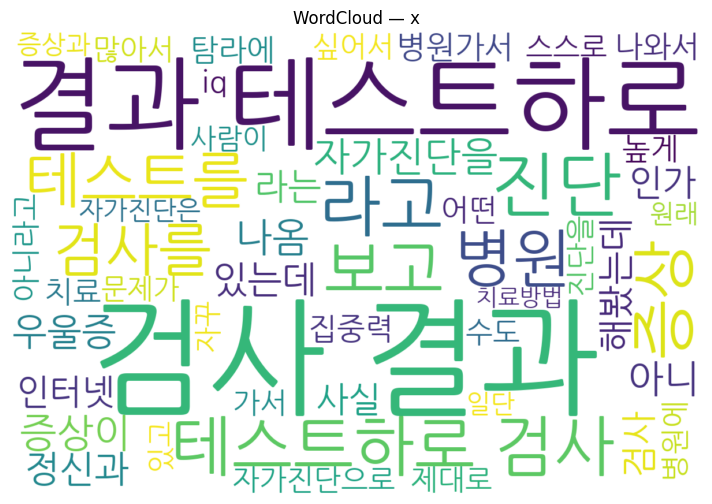

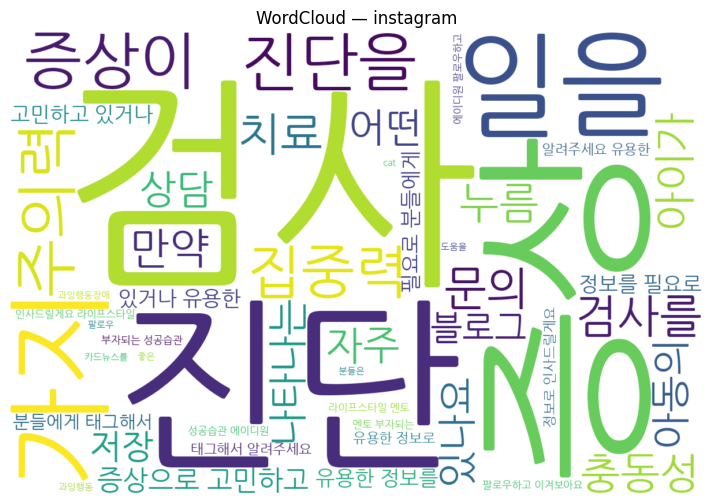

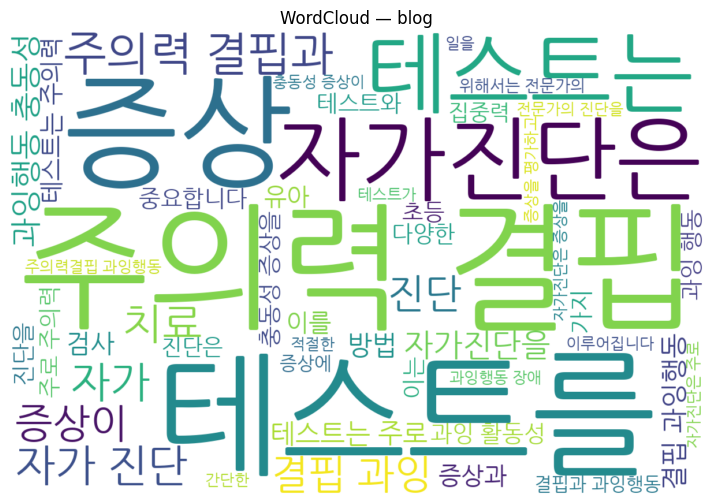

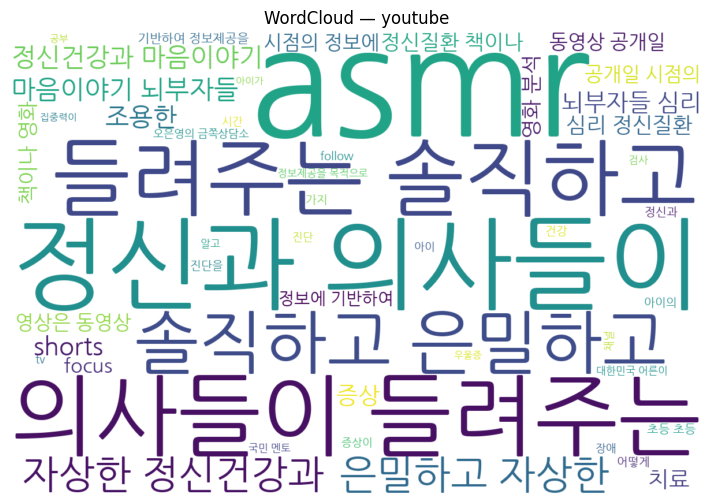

✅ WordCloud saved to outputs/wordclouds/


In [ ]:
def make_wordcloud(text, title, save_path=None):
    wc = WordCloud(
        width=1200, height=800,
        background_color='white',
        font_path=KOREAN_FONT if KOREAN_FONT else None,
        max_words=50
    ).generate(text)
    plt.figure(figsize=(10,6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()
    if save_path:
        wc.to_file(save_path)

os.makedirs('outputs', exist_ok=True)
os.makedirs('outputs/wordclouds', exist_ok=True)
for p in platforms:
    sub = df[df['platform'] == p]
    text_all = ' '.join(sub['clean_text'].dropna().tolist())
    if not text_all.strip():
        print(f"⚠️ {p}: 텍스트 없음 → 워드클라우드 생략")
        continue
    save_path = f"outputs/wordclouds/wordcloud_{p}.png"
    make_wordcloud(text_all, f"WordCloud — {p}", save_path=save_path)
print("✅ WordCloud saved to outputs/wordclouds/")

## 8) 시각화 — 연도별 KPI 라인 차트
- Matplotlib 단일 플롯 규칙 준수
- 각각 **likecount**, **commentcount**, **viewcount**, **kpi_score** 4개 차트를 별도로 출력

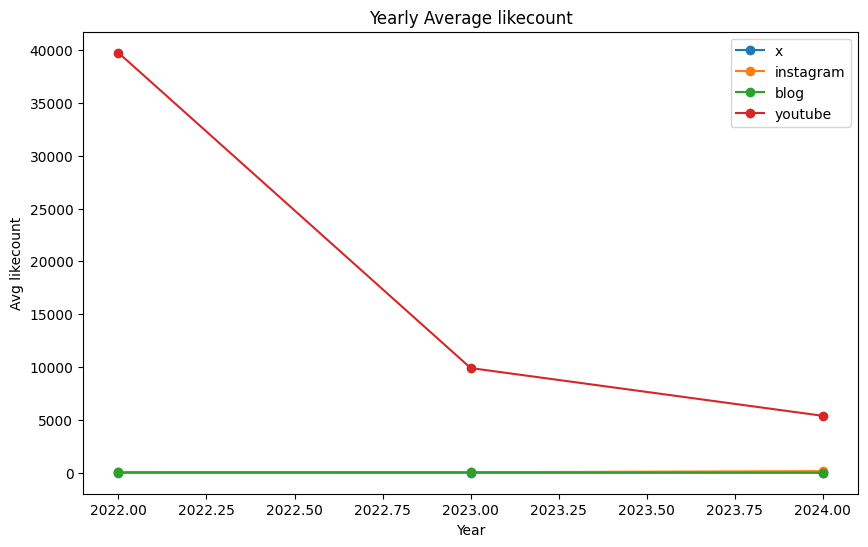

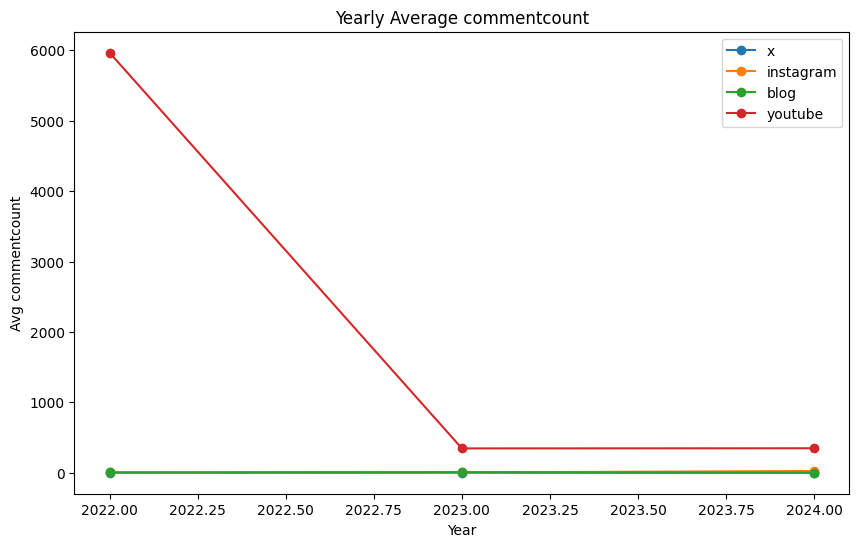

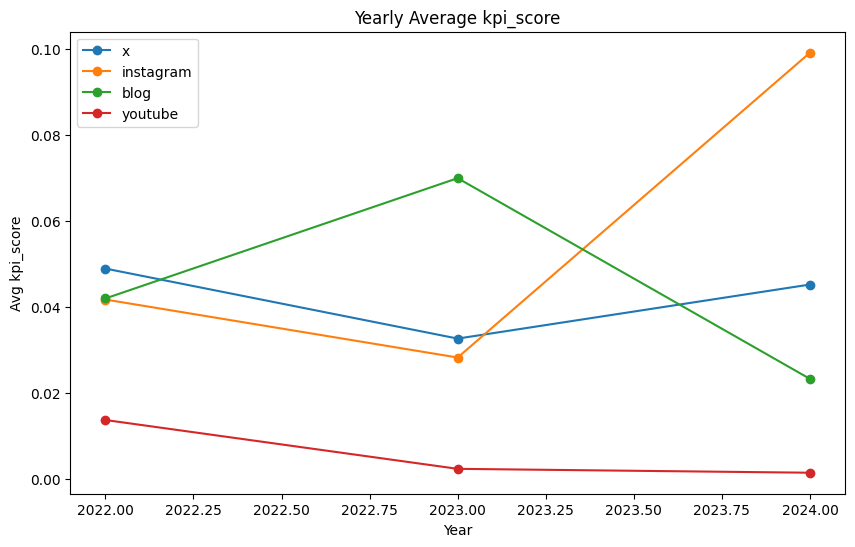

In [ ]:
def plot_yearly_metric(metric_name: str):
    if not df['created_at'].notnull().any():
        print("연도 정보가 없어 연도별 차트 생략.")
        return
    plt.figure(figsize=(10,6))
    for p in platforms:
        sub = df[(df['platform']==p) & df['created_at'].notnull()]
        if sub.empty:
            continue
        series = sub.groupby('created_at')[metric_name].mean().sort_index()
        if series.empty:
            continue
        plt.plot(series.index, series.values, marker='o', label=p)
    plt.title(f"Yearly Average {metric_name}")
    plt.xlabel("Year")
    plt.ylabel(f"Avg {metric_name}")
    plt.legend()
    plt.show()

for m in ['likecount','commentcount','kpi_score']:
    plot_yearly_metric(m)


## 9) 결과물 저장/다운로드 (선택)
- 주요 CSV와 WordCloud 이미지를 ZIP으로 묶어 한 번에 다운로드 가능
- Colab 환경에서 `files.download` 사용

In [ ]:
zip_path = 'outputs/platform_kpi_wordcloud_results.zip'
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zf:
    for root, dirs, files in os.walk('outputs'):
        for f in files:
            fp = os.path.join(root, f)
            zf.write(fp)
print("✅ Zipped:", zip_path)

try:
    from google.colab import files
    files.download(zip_path)
except Exception:
    print("(Info) Colab이 아니면 수동으로 파일을 다운로드하세요.")


---
### 🔧 참고/커스터마이즈
- **불용어 추가/삭제**: `CUSTOM_STOPWORDS` 집합을 수정
- **합성 KPI 가중치**: 현재는 **동일 가중 평균**. 특정 지표에 가중치를 주고 싶다면 아래처럼 변경 가능:

```python
w_like, w_comm, w_view = 1.0, 1.0, 1.0
den = (w_like>0) + (w_comm>0) + (w_view>0)
df['kpi_score'] = (
    w_like*df['norm_likecount'] + w_comm*df['norm_commentcount'] + w_view*df['norm_viewcount']
) / max(den, 1)
```
- **WordCloud 단어 수 변경**: `max_words` 파라미터 조정
- **CSV 파일명/경로 변경**: 상단 `CSV_PATH` 변수 수정